In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display
import librosa.display
import numpy as np
import librosa
import tensorflow as tf
import glob

In [2]:
drone_path = '../../../1mtmp/*.wav'
background_path = '../../data/test_background/second*.wav'

drone_files = glob.glob(drone_path)
background_files = glob.glob(background_path)

In [3]:
CHUNK_SIZE = 8192
SR = 22050
N_MFCC = 16

In [4]:
def load(files, sr=22050):
    [raw, sr] = librosa.load(files[0], sr=sr)
    for f in files[1:]:
        [array, sr] = librosa.load(f, sr=sr)
        raw = np.hstack((raw, array))
    print(raw.shape)
    return raw

In [5]:
drone_raw = load(drone_files)
background_raw = load(background_files)

(512000,)
(20480,)


In [6]:
def mfcc4(raw, label, chunk_size=8192, window_size=4096, sr=22050, n_mfcc=16, n_frame=16):
    mfcc = np.empty((0, n_mfcc, n_frame))
    y = []
    print(raw.shape)
    for i in range(0, len(raw), chunk_size//2):
        mfcc_slice = librosa.feature.mfcc(raw[i:i+chunk_size], sr=sr, n_mfcc=n_mfcc) #n_mfcc,17
        if mfcc_slice.shape[1] < 17:
            print(i,">small end:", mfcc_slice.shape)
            continue
        mfcc_slice = mfcc_slice[:,:-1]
        mfcc_slice = mfcc_slice.reshape((1, mfcc_slice.shape[0], mfcc_slice.shape[1]))
        mfcc = np.vstack((mfcc, mfcc_slice))
        y.append(label)
    y = np.array(y)
    return mfcc, y

In [7]:
mfcc_drone, y_drone = mfcc4(drone_raw, 1)
mfcc_background, y_background = mfcc4(background_raw, 0)

print(mfcc_drone.shape, y_drone.shape)
print(mfcc_background.shape, y_background.shape)

(512000,)
507904 >small end: (16, 9)
(20480,)
16384 >small end: (16, 9)
(124, 16, 16) (124,)
(4, 16, 16) (4,)


In [8]:
X = np.concatenate((mfcc_drone, mfcc_background), axis=0)
y = np.hstack((y_drone, y_background))
print(X.shape, y.shape)

(128, 16, 16) (128,)


In [9]:
X_test = X.reshape(X.shape[0],-1)
print(X_test.shape)
print(type(X_test))

(128, 256)
<class 'numpy.ndarray'>


In [10]:
#X_train2 = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1) ############# 리셰입 해야 

In [11]:
n_labels = y.shape[0]
n_unique_labels = 2
y_encoded = np.zeros((n_labels, n_unique_labels))
y_encoded[np.arange(n_labels), y] = 1
print(y_encoded.shape)

(128, 2)


# test init

In [12]:
n_mfcc = 16
n_frame = 16
n_classes = 2
n_channels = 1

kernel_size = 3
stride = 1
pad = "SAME"

learning_rate = 0.0002

In [13]:
X = tf.placeholder(tf.float32, shape=[None,n_mfcc*n_frame*n_channels])
#X = tf.reshape(X, [-1, n_mfcc, n_frame, n_channels]) #fully connected에는 리셰입 안해도 된다 
Y = tf.placeholder(tf.float32, shape=[None,n_classes])

keep_prob = tf.placeholder(tf.float32)

#dense2 = tf.layers.dense(inputs=flat, units=625, activation=tf.nn.relu)
#dropout2 = tf.layers.dropout(inputs=dense2, rate=0.5, training=True)
dense1 = tf.layers.dense(inputs=X, units=256, activation=tf.nn.relu)
dropout1 = tf.nn.dropout(dense1, keep_prob=keep_prob)
dense2 = tf.layers.dense(inputs=dropout1, units=256, activation=tf.nn.relu)
dropout2 = tf.nn.dropout(dense2, keep_prob=keep_prob)
dense3 = tf.layers.dense(inputs=dropout2, units=512, activation=tf.nn.relu)
dropout3 = tf.nn.dropout(dense3, keep_prob=keep_prob)
#이거 지워보고 돌려보고 
dense4 = tf.layers.dense(inputs=dropout3, units=512, activation=tf.nn.relu)
dropout4 = tf.nn.dropout(dense4, keep_prob=keep_prob)
dense5 = tf.layers.dense(inputs=dropout4, units=256, activation=tf.nn.relu)
dropout5 = tf.nn.dropout(dense5, keep_prob=keep_prob)

logits= tf.layers.dense(inputs=dropout5, units=2)

In [14]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [15]:
# Model Save
sess=tf.Session()
saver = tf.train.Saver()
saver.restore(sess, '../../model/Dense/dense_model')

INFO:tensorflow:Restoring parameters from ../../model/Dense/dense_model


In [16]:
# Prediction
y_test = sess.run(tf.nn.softmax(logits), feed_dict={X: X_test, keep_prob:1})
y_pred = sess.run(tf.argmax(logits,1),feed_dict={X: X_test,keep_prob:1 })
y_true = sess.run(tf.argmax(y_encoded,1))

import pandas as pd
pd.options.display.max_rows = 4000
print(pd.DataFrame(y_test))

                0             1
0    1.246278e-30  1.000000e+00
1    1.657266e-22  1.000000e+00
2    2.347753e-22  1.000000e+00
3    3.692449e-22  1.000000e+00
4    3.101794e-30  1.000000e+00
5    0.000000e+00  1.000000e+00
6    8.885591e-34  1.000000e+00
7    6.013129e-30  1.000000e+00
8    4.915927e-36  1.000000e+00
9    3.026734e-35  1.000000e+00
10   5.558082e-20  1.000000e+00
11   5.692480e-17  1.000000e+00
12   6.516880e-18  1.000000e+00
13   5.954956e-18  1.000000e+00
14   1.500827e-24  1.000000e+00
15   6.272971e-23  1.000000e+00
16   1.373752e-25  1.000000e+00
17   1.865743e-26  1.000000e+00
18   3.640071e-16  1.000000e+00
19   3.531278e-26  1.000000e+00
20   5.815701e-33  1.000000e+00
21   1.360051e-29  1.000000e+00
22   5.610120e-28  1.000000e+00
23   2.409635e-29  1.000000e+00
24   8.432815e-28  1.000000e+00
25   2.947738e-25  1.000000e+00
26   8.122502e-16  1.000000e+00
27   1.766674e-09  1.000000e+00
28   7.744599e-10  1.000000e+00
29   6.495608e-26  1.000000e+00
30   8.7

In [17]:
sum = 0
for i in range(0, len(y_test)-4):
    sum = sum + y_test[i][1]
print(sum, sum/(len(y_test)-4))

124.0 1.0


F-Score: 1.0
Accuracy:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00       124

   micro avg       1.00      1.00      1.00       128
   macro avg       1.00      1.00      1.00       128
weighted avg       1.00      1.00      1.00       128

[[  4   0]
 [  0 124]]


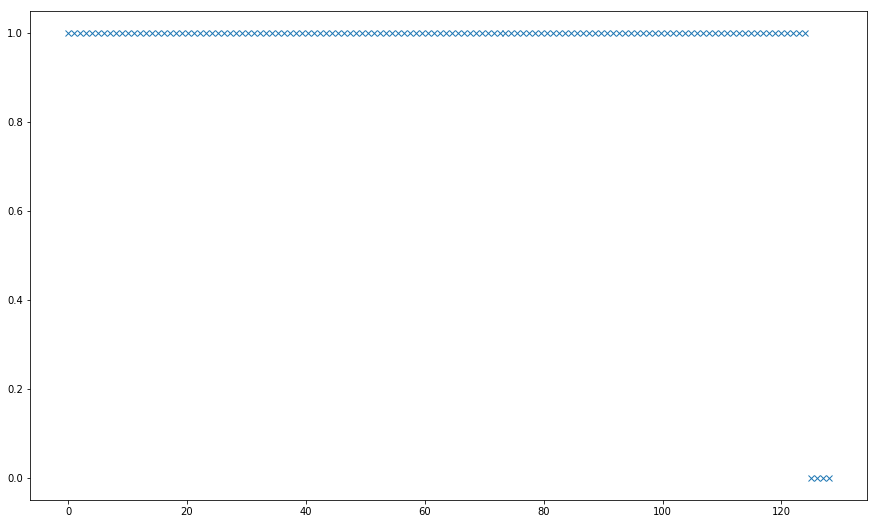

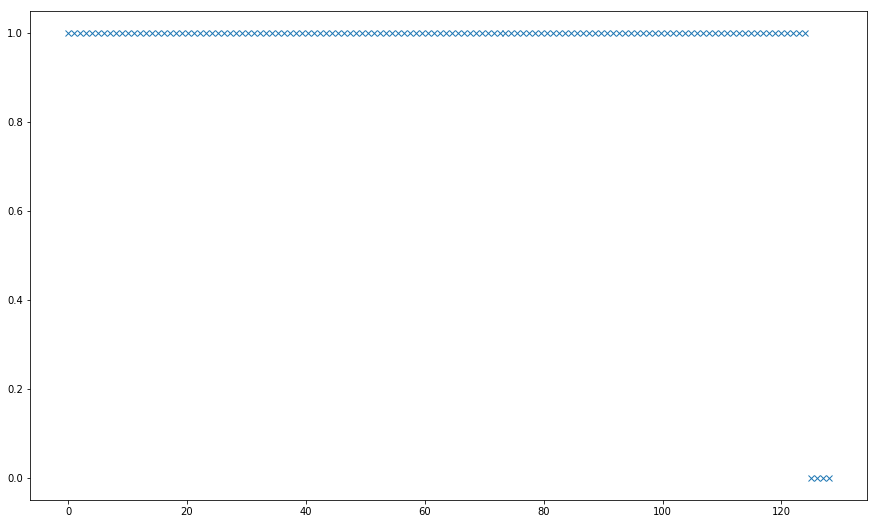

In [18]:
# Print Result

from sklearn.metrics import precision_recall_fscore_support
y_true = y_true
y_pred = y_pred

p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print("F-Score:", round(f,2))
from sklearn.metrics import accuracy_score
print("Accuracy: ", accuracy_score(y_true, y_pred))


fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(1,1,1)
ax.plot(np.linspace(0,len(y_pred), len(y_pred)),y_true, 'x')

fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(1,1,1)
ax.plot(np.linspace(0,len(y_pred), len(y_pred)),y_pred, 'x')

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true, y_pred))